In [1]:
import os    
import cv2  
import argparse
import time
import numpy as np
from scipy import ndimage
from skimage.transform import resize

from utils.depth_utils import *
from utils.register_utils import *

from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers.utils import load_image

from rembg import remove
from diffusers.utils import make_image_grid

from hy3dgen.texgen import Hunyuan3DPaintPipeline
from hy3dgen.shapegen import Hunyuan3DDiTFlowMatchingPipeline

hunyuan3D_mesh_pipe = Hunyuan3DDiTFlowMatchingPipeline.from_pretrained('tencent/Hunyuan3D-2')
# hunyuan3D_paint_pipe = Hunyuan3DPaintPipeline.from_pretrained('tencent/Hunyuan3D-2')

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
)

d2i_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

d2i_pipe.scheduler = UniPCMultistepScheduler.from_config(d2i_pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
d2i_pipe.enable_xformers_memory_efficient_attention()

d2i_pipe.enable_model_cpu_offload()
d2i_pipe.to("cuda")


data_map_txt={"01184":"An outdoor trash can with wheels", # Wheelie-Bin
              "06127":"A plant in a large vase", # vase
              "06830":"Children's tricycle with adult's handle" , # tricycle
              "07306":"An office trash can", # trash can
              "05452":"An a outside chair", # arm chair
              "06145":"A one leg square table", # table
              "05117":"A chair", # chair
              "06188":"A motorcycle", # vespa
              "07136":"A couch", # sofa
              "09639":"An executive chair"} # Swivel chair

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2025-05-05 22:39:36,345 - hy3dgen.shapgen - INFO - Try to load model from local path: /home/warrenz/.cache/hy3dgen/tencent/Hunyuan3D-2/hunyuan3d-dit-v2-0
2025-05-05 22:39:36,345 - hy3dgen.shapgen - INFO - Model path not exists, try to download from huggingface


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

2025-05-05 22:39:36,498 - hy3dgen.shapgen - INFO - Loading model from /home/warrenz/.cache/huggingface/hub/models--tencent--Hunyuan3D-2/snapshots/34e28261f71c32975727be8db0eace439a280f82/hunyuan3d-dit-v2-0/model.fp16.safetensors


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, contr

In [2]:
# params
parser = argparse.ArgumentParser()
parser.add_argument(
    "--obj_id",
    type=str,
    default="09639",
    choices=data_map_txt.keys(),
    help="Object ID to process",
)
parser.add_argument(
    "--verbose",
    action="store_true",
    help="Enable verbose output",
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="./output",
    help="Directory to save output images",
)
parser.add_argument(
    "--gen_rgb",
    action="store_true",
    help="Generate RGB image using ControlNet",
)
parser.add_argument(
    "--depth_inpainting",
    action="store_true",
    help="Enable depth inpainting",
)
parser.add_argument(
    "--inference_steps",
    type=int,
    default=100,
    help="Number of inference steps for image generation",
)
parser.add_argument(
    "--seed",
    type=int,
    default=42,
    help="Random seed for reproducibility",
)
args = parser.parse_args(['--obj_id', '09639', 
                          '--verbose', 
                          '--gen_rgb', 
                          '--depth_inpainting', 
                          '--inference_steps', '100'])
print(args)

Namespace(obj_id='09639', verbose=True, output_dir='./output', gen_rgb=True, depth_inpainting=True, inference_steps=100, seed=42)


In [3]:
# Set the random seed for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)

object_id = args.obj_id
verbose = args.verbose
depth_inpainting = args.depth_inpainting
output_dir = args.output_dir
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Start the timer
start_time = time.time()

In [5]:
pcl_path = f'./redwood_dataset/point_clouds/{object_id}.ply'
partial_pcl = o3d.io.read_point_cloud(pcl_path)
partial_pcl_translate = -partial_pcl.get_center()
partial_pcl = partial_pcl.translate(partial_pcl_translate)
partial_pcl_scale = 1.0 / np.max(np.linalg.norm(np.asarray(partial_pcl.points), axis=1))
partial_pcl_scale_center = np.asarray((0, 0, 0))
partial_pcl = partial_pcl.scale(partial_pcl_scale, center=partial_pcl_scale_center)
partial_pcl = np.asarray(partial_pcl.points)

In [13]:
_, _, best_depth_map, best_depth_map_low, _ = find_best_camera_iter_w_low(partial_pcl, 
                                                                        n_cam_hull=500, 
                                                                        n_cam_depth_iter=150, 
                                                                        radius=2.0,
                                                                        width=512,
                                                                        height=512,
                                                                        fov_deg=60,
                                                                        low_res_ratio=1/8)

depth_map_c = cv2.medianBlur(best_depth_map.astype(np.float32), 5)

Computing visibility with convex hull: 100%|██████████| 500/500 [00:03<00:00, 128.99it/s]


[INFO] Best camera position: [-0.63082376 -0.22935864 -1.884     ]
[INFO] Best visible count: 1778
[INFO] Current radius: 1.6817928305074292


Computing visibility with depth map: 100%|██████████| 150/150 [00:02<00:00, 68.67it/s]


[INFO] Best camera position: [-0.04145796 -0.09958463 -1.99708892]
[INFO] Best visible count: 46314
Iteration: 1 Best visible count: 46314
[INFO] Current radius: 1.414213562373095


Computing visibility with depth map: 100%|██████████| 150/150 [00:02<00:00, 67.14it/s]


[INFO] Best camera position: [-0.09209424  0.0752353  -1.99646144]
[INFO] Best visible count: 46540
Iteration: 2 Best visible count: 46540
[INFO] Current radius: 1.189207115002721


Computing visibility with depth map: 100%|██████████| 150/150 [00:02<00:00, 66.44it/s]


[INFO] Best camera position: [-0.14440234 -0.03137094 -1.99453349]
[INFO] Best visible count: 46609
Iteration: 3 Best visible count: 46609
[INFO] Current radius: 1.0


Computing visibility with depth map: 100%|██████████| 150/150 [00:02<00:00, 66.70it/s]


[INFO] Best camera position: [-0.09069409 -0.01050852 -1.99791495]
[INFO] Best visible count: 46800
Iteration: 4 Best visible count: 46800
[INFO] Current radius: 0.8408964152537146


Computing visibility with depth map: 100%|██████████| 150/150 [00:02<00:00, 66.64it/s]


[INFO] Best camera position: [-0.04547783  0.00707136 -1.99947037]
[INFO] Best visible count: 46876
Iteration: 5 Best visible count: 46876
[INFO] Current radius: 0.7071067811865475


Computing visibility with depth map: 100%|██████████| 150/150 [00:02<00:00, 65.98it/s]

Iteration: 6 Best visible count: 46876
[INFO] Best camera position: [-0.04547783  0.00707136 -1.99947037]
[INFO] Best visible count: 46876


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

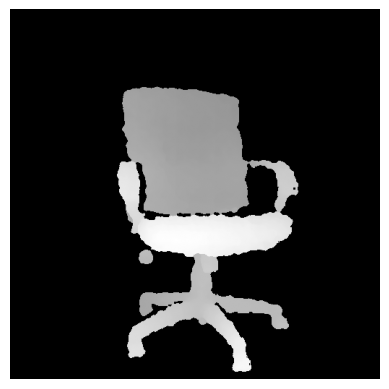

In [14]:
plt.imshow(depth_map_c, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

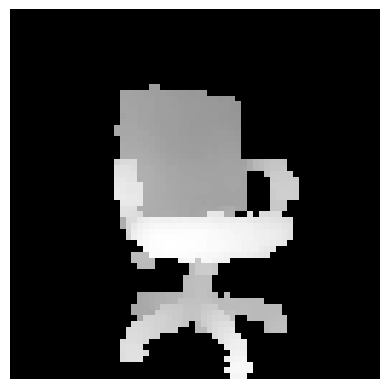

In [15]:
plt.imshow(best_depth_map_low, cmap='gray')
plt.axis('off')

In [16]:
if depth_inpainting:
    depth_map_c = cv2.medianBlur(best_depth_map.astype(np.float32), 5)
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    depth_map_binary = cv2.threshold(depth_map_c, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_binary_low = cv2.threshold(best_depth_map_low, 0, 1, cv2.THRESH_BINARY)[1]
    depth_map_binary_low = cv2.GaussianBlur(depth_map_binary_low, (5,5), sigmaX=1.0, sigmaY=1.0)
    depth_map_binary_low_up = cv2.resize(depth_map_binary_low, (depth_map_c.shape[1], depth_map_c.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    depth_map_binary_low_up = cv2.threshold(depth_map_binary_low_up, 0.5, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_xor = cv2.bitwise_xor(depth_map_binary, depth_map_binary_low_up)
    depth_map_xor[depth_map_binary != 0] = 0
    
    from diffusers import StableDiffusionInpaintPipeline
    from PIL import Image
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    )

    pipe.to("cuda")
    prompt = data_map_txt[object_id]
    negative_prompt = "bad anatomy, deformed, ugly, disfigured, intricate details, blurry, out of focus, bad art, bad anatomy, disfig"
    #image and mask_image should be PIL images.
    # convert the depth map to a PIL image
    depth_map_image = cv2.normalize(depth_map_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_map_image = cv2.cvtColor(depth_map_image, cv2.COLOR_GRAY2RGB)
    depth_map_image = cv2.resize(depth_map_image, (512, 512), interpolation=cv2.INTER_NEAREST)
    # convert the binary mask to a PIL image
    mask_image = cv2.normalize(depth_map_xor, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)
    mask_image = cv2.resize(mask_image, (512, 512), interpolation=cv2.INTER_NEAREST)
    #The mask structure is white for inpainting and black for keeping as is
    depth_map = pipe(prompt=prompt, 
                        negative_prompt=negative_prompt, 
                        image=Image.fromarray(depth_map_image), 
                        mask_image=Image.fromarray(mask_image),
                num_inference_steps=100,
                guidance_scale=2.0
                ).images[0]
    depth_map = np.array(depth_map)
    make_image_grid([Image.fromarray(depth_map_image), 
                     Image.fromarray(mask_image), 
                     Image.fromarray(depth_map)], rows=1, cols=3).save(
                         os.path.join(output_dir, f"{object_id}_depth_inpaint.png"))
else:
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    depth_map = cv2.normalize(depth_map_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # increase a little bit contrast
    depth_map = cv2.convertScaleAbs(depth_map, alpha=0.9, beta=0)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2RGB)
    depth_map = cv2.resize(depth_map, (512, 512), interpolation=cv2.INTER_NEAREST)
    make_image_grid([Image.fromarray(depth_map)], rows=1, cols=1).save(os.path.join(output_dir, f"{object_id}_depth.png"))

# depth_map = cv2.flip(depth_map, 1)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

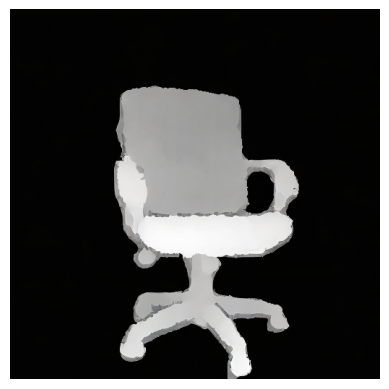

In [17]:
plt.imshow(depth_map)
plt.axis('off')
plt.show()

In [18]:
if args.gen_rgb:
    print("[INFO] Depth map generated, now generating image using ControlNet...")
    # auxiliary_prompt = ", clean background, no people, no animals"
    auxiliary_prompt = ""
    image = d2i_pipe(data_map_txt[object_id] + auxiliary_prompt,
                    Image.fromarray(depth_map), 
                    num_inference_steps=args.inference_steps,
                    # num_inference_steps=75,
                    guidance_scale = 6.0,
                    controlnet_conditioning_scale=1.1,
                    negative_prompt="bad anatomy, deformed, ugly, disfigured, \
                    intricate details, blurry, out of focus, bad art, bad anatomy",
                    # negative_prompt = "bad anatomy, deformed, ugly, disfigured, intricate details, blurry, out of focus, bad art, bad anatomy, disfig, intricate background",
                    # generator=torch.manual_seed(0),
                    generator=torch.manual_seed(42),
                    ).images[0]
    image = remove(image)
else:
    depth_map_gray = cv2.cvtColor(depth_map, cv2.COLOR_RGB2GRAY)
    depth_map_gray = cv2.normalize(depth_map_gray, None, 0, 1, cv2.NORM_MINMAX)
    depth_map_binary = cv2.threshold(depth_map_gray, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_binary = cv2.medianBlur(depth_map_binary.astype(np.float32), 5)
    depth_map_rgba = cv2.cvtColor(depth_map, cv2.COLOR_RGB2RGBA)
    depth_map_rgba[depth_map_binary == 0] = (0, 0, 0, 0)
    depth_map_rgba = Image.fromarray(depth_map_rgba.astype(np.uint8))
    image = depth_map_rgba.copy()

[INFO] Depth map generated, now generating image using ControlNet...


  0%|          | 0/100 [00:00<?, ?it/s]

[INFO] Image prompt for Hunyuan3D:


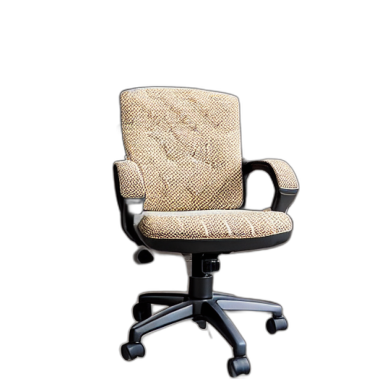

In [19]:
print("[INFO] Image prompt for Hunyuan3D:")
plt.imshow(image)
plt.axis('off')
plt.show()
image.save(os.path.join(output_dir, f"{object_id}_img_prompt.png"))

In [20]:
print("[INFO] Background removed, now generating mesh using Hunyuan3D...")
mesh = hunyuan3D_mesh_pipe(image=image,
                      num_inference_steps=args.inference_steps,
                      guidance_scale = 4.5,
                      )[0]
# print("[INFO] Mesh generated, now generating texture using Hunyuan3D...")
# mesh = hunyuan3D_paint_pipe(mesh=mesh,
#                             image=image_nobg,
#                             )[0]
# Save the mesh to a file
print("[INFO] Saving mesh...")
mesh.export(os.path.join(output_dir, f"{object_id}_mesh.ply"))
print(f"Mesh saved to {os.path.join(output_dir, f'{object_id}_mesh.ply')}")


[INFO] Background removed, now generating mesh using Hunyuan3D...


Diffusion Sampling::   0%|          | 0/100 [00:00<?, ?it/s]

Volume Decoding: 100%|██████████| 7134/7134 [00:16<00:00, 440.84it/s]


[INFO] Saving mesh...
Mesh saved to ./output/09639_mesh.ply


In [21]:
from open3d.web_visualizer import draw

# Visualize the mesh
print("[INFO] Visualizing mesh...")
mesh = o3d.io.read_triangle_mesh(os.path.join(output_dir, f"{object_id}_mesh.ply"))
mesh.vertices = o3d.utility.Vector3dVector(np.asarray(mesh.vertices) * np.array([-1, 1, 1]))

draw([mesh])


[Open3D INFO] Resetting default logger to print to terminal.
[INFO] Visualizing mesh...
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
FEngine (64 bits) created at 0x7ed0a8009510 (threading is enabled)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
EGL(1.5)
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

In [22]:
# Register the mesh to the original point cloud
print("[INFO] Registering mesh to original point cloud...")

object_id = args.obj_id
# object_id = "01184"\

np.random.seed(42)

# Load the ground truth mesh
complete_pcd = o3d.io.read_triangle_mesh(f"./redwood_dataset/GT/{object_id}.ply")
complete_pcd = complete_pcd.sample_points_uniformly(number_of_points=16384)
complete_pcd.points = o3d.utility.Vector3dVector(-np.asarray(complete_pcd.points))
translate = -complete_pcd.get_center()
complete_pcd = complete_pcd.translate(translate)
scale = 0.5 / np.max(np.linalg.norm(np.asarray(complete_pcd.points), axis=1))
complete_pcd = complete_pcd.scale(scale, center=complete_pcd.get_center())

# Load the partial point cloud
partial_pcd = o3d.io.read_point_cloud(f"./redwood_dataset/point_clouds/{object_id}.ply")
partial_pcd.points = o3d.utility.Vector3dVector(-np.asarray(partial_pcd.points))
partial_pcd = partial_pcd.translate(translate)
partial_pcd = partial_pcd.scale(scale, center=complete_pcd.get_center())
partial_pcd = partial_pcd.farthest_point_down_sample(num_samples=16384)

# Load the generated mesh
mesh = o3d.io.read_triangle_mesh(os.path.join(output_dir, f"{object_id}_mesh.ply"))
# Normalize the mesh
mesh = mesh.translate(-mesh.get_center())
mesh = mesh.scale(0.5 / np.max(np.linalg.norm(np.asarray(mesh.vertices), axis=1)), center=mesh.get_center())
mesh_pcd = mesh.sample_points_uniformly(number_of_points=16384)
mesh_pcd.points = o3d.utility.Vector3dVector(np.asarray(mesh_pcd.points) * np.array([-1, 1, 1]))

# # Register the mesh to the original point cloud
# scales = np.arange(0.8, 1.25, 0.025)
# # scales = np.meshgrid(scales, scales, scales)
# # scales = np.array(scales).reshape(3, -1).T
# # print(f"Number of scales: {scales[..., None].shape}")
# transformation = multiscale_registration(mesh_pcd, partial_pcd, scales, voxel_size=0.0025)

# mesh_pcd.transform(transformation)

from utils.gd_register_utils import gd_registration
mesh_pcd = gd_registration(mesh_pcd, partial_pcd, fps_sample=2048, device='cuda')

# mesh_pcd.transform(transformation)

# Compute the chamfer distance
cd_o3d = (np.mean(complete_pcd.compute_point_cloud_distance(mesh_pcd)) + \
    np.mean(mesh_pcd.compute_point_cloud_distance(complete_pcd))) / 2
print(f"Chamfer Distance: {cd_o3d}")

# from utils.chamfer_python import distChamfer
# cd_left, cd_right, index_left, index_right = distChamfer(torch.tensor(np.asarray(complete_pcd.points)).unsqueeze(0), 
#                  torch.tensor(np.asarray(mesh_pcd.points)).unsqueeze(0))
# print(cd_left.shape, cd_right.shape)
# cd = (cd_left.sqrt().mean(dim=1) + cd_right.sqrt().mean(dim=1))
# print(f"Chamfer Distance (PyTorch): {cd.item()}")

[INFO] Registering mesh to original point cloud...
Target point cloud shape: torch.Size([2048, 3])
Source point cloud shape: torch.Size([2048, 3])
Stage 1: Joint optimization of rotation, translation, and scale
Iteration    0: Loss = 0.001736
Iteration  100: Loss = 0.000558
Iteration  200: Loss = 0.000558
Iteration  300: Loss = 0.000558
Iteration  400: Loss = 0.000559
Iteration  500: Loss = 0.000558
Iteration  600: Loss = 0.000558
Iteration  700: Loss = 0.000558
Iteration  800: Loss = 0.000558
Iteration  900: Loss = 0.000562
Stage 2: Only optimize translation and scale
Iteration    0: Loss = 0.000559
Iteration  100: Loss = 0.000558
Iteration  200: Loss = 0.000563
Optimization complete.
Learned rotation angles (radians): [ 0.11298672 -0.2921627  -0.04753236]
Learned translation: [-0.00165579 -0.05437963  0.0274387 ]
Learned scale: [0.98655474]
Chamfer Distance: 0.021830342538582202


In [ ]:
# Write the registered mesh to a file
o3d.io.write_point_cloud(os.path.join(output_dir, f"{object_id}_pcd_complete_registered.ply"), mesh_pcd)

True

In [ ]:
mesh_pcd.paint_uniform_color([0, 0, 1])
partial_pcd.paint_uniform_color([1, 0, 0])
complete_pcd.paint_uniform_color([0, 1, 0])
draw([mesh_pcd, partial_pcd, complete_pcd])

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

In [ ]:

draw([mesh_pcd, partial_pcd])

[Open3D INFO] Window window_2 created.


WebVisualizer(window_uid='window_2')

In [ ]:
# Show run time
end_time = time.time()
print(f"[INFO] Total run time: {end_time - start_time:.2f} seconds")
print(f"[INFO] Final Chamfer Distance: {cd_o3d:.4f}")
print(f"[INFO] Output saved to {output_dir}")

[INFO] Total run time: 52.55 seconds
[INFO] Final Chamfer Distance: 0.0261
[INFO] Output saved to ./output
